## 摘要

- 30分後の為替の変動を予測してみる

### データセット

- [GAIN Capital](http://ratedata.gaincapital.com/)
- 通貨ペア: USD/JPY
- 期間: 2018-03-04 〜 2018-04-19

### 前提条件

- 0.3銭(0.0015%の手数料)を取られる

### 売買の方針

- 30分後の為替の変動を予測し，何もしない, 買い， 売りを決定する．
- 30秒単位で売り買いの判断を行う．
- 3銭(0.015%)以上変動しそうなら売り買いする．
- ある程度自信があるときしか買わない．

| 行動        | 値 | 説明                                      |
| ------------ | --- | ------------------------------------------- |
| 買い        | 1  |  現在の買値(Ask) < 将来の売値(Bid) |
| 空売り      | 2 |  現在の売値(Bid) > 将来の買値(Ask) |
| 何もしない | 0  |  それ以外 |    

In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline
import xgboost as xgb
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

ACTION_DO_NOTHING = 0
ACTION_LONG = 1 # 買い
ACTION_SHORT = 2 # 空売り
ACTION_NAMES = [u"do nothing", u"long", u"short"]

In [2]:
df = pd.concat([pd.read_csv(fpath, parse_dates=["RateDateTime"]) for fpath in sorted(glob.glob("*.csv"))])

In [3]:
df = df.sort_values(by="RateDateTime").reset_index(drop=True)

In [4]:
df.head()

,lTid,cDealable,CurrencyPair,RateDateTime,RateBid,RateAsk
0,6474889452,D,USD/JPY,2018-03-04 17:00:09.560,105.419,105.489
1,6474889479,D,USD/JPY,2018-03-04 17:00:17.810,105.462,105.532
2,6474889521,D,USD/JPY,2018-03-04 17:00:26.060,105.458,105.528
3,6474889554,D,USD/JPY,2018-03-04 17:00:35.310,105.476,105.546
4,6474889598,D,USD/JPY,2018-03-04 17:00:38.310,105.461,105.531


In [5]:
df = df.set_index("RateDateTime", drop=True).resample("30S").mean().reset_index()

In [6]:
df.head()

,RateDateTime,lTid,RateBid,RateAsk
0,2018-03-04 17:00:00,6.474889e+09,105.446333,105.516333
1,2018-03-04 17:00:30,6.474890e+09,105.470500,105.540500
2,2018-03-04 17:01:00,6.474890e+09,105.480000,105.550000
3,2018-03-04 17:01:30,6.474890e+09,105.482500,105.552500
4,2018-03-04 17:02:00,6.474890e+09,105.480667,105.550667


In [7]:
df.describe()

,lTid,RateBid,RateAsk
count,9.877300e+04,98773.000000,98773.000000
mean,6.532411e+09,106.455745,106.461792
std,3.202130e+07,0.682563,0.682517
min,6.474889e+09,104.640000,104.657500
25%,6.504177e+09,106.007214,106.012886
50%,6.534282e+09,106.455700,106.462870
75%,6.560417e+09,107.035909,107.041280
max,6.585344e+09,107.849065,107.854043


In [8]:
T = 60 # 30分後
# T = 30 # 15分後
margin = 0.03 # 3銭の変動
df["TargetRateBid"] = df["RateBid"].shift(-T)
df["TargetRateAsk"] = df["RateAsk"].shift(-T)
df["TargetRateDateTime"] = df["RateDateTime"].shift(-T)
df["Target"] = ACTION_DO_NOTHING # 何もしない
df.loc[(df["TargetRateBid"] > df["RateAsk"] + margin), "Target"] = ACTION_LONG # 買いのタイミング
df.loc[(df["TargetRateAsk"] + margin < df["RateBid"]), "Target"] = ACTION_SHORT # 売りのタイミング

In [9]:
df.head()

,RateDateTime,lTid,RateBid,RateAsk,TargetRateBid,TargetRateAsk,TargetRateDateTime,Target
0,2018-03-04 17:00:00,6.474889e+09,105.446333,105.516333,105.556923,105.605846,2018-03-04 17:30:00,1
1,2018-03-04 17:00:30,6.474890e+09,105.470500,105.540500,105.556864,105.602682,2018-03-04 17:30:30,0
2,2018-03-04 17:01:00,6.474890e+09,105.480000,105.550000,105.574750,105.609650,2018-03-04 17:31:00,0
3,2018-03-04 17:01:30,6.474890e+09,105.482500,105.552500,105.564622,105.605333,2018-03-04 17:31:30,0
4,2018-03-04 17:02:00,6.474890e+09,105.480667,105.550667,105.561203,105.604331,2018-03-04 17:32:00,0


### 特徴抽出

In [10]:
# 時間関連
df["Dow"] = df["RateDateTime"].dt.dayofweek
df["Month"] = df["RateDateTime"].dt.month
df["Day"] = df["RateDateTime"].dt.day
df["Hour"] = df["RateDateTime"].dt.hour
df["Minute"] = df["RateDateTime"].dt.minute

# 板の乖離度
df["RateAsk-RateBid"] = df["RateAsk"] - df["RateBid"]

use_columns = ["Dow", "Month", "Day", "Hour", "Minute", "RateAsk-RateBid"]

# 直近の価格との差
intervals = [2, 3, 5, 8, 13, 21, 34, 55]
for interval in intervals:
    column = "RateBidDiff_%05dm" % interval
    df[column] = df["RateBid"] - df["RateBid"].shift(interval)
    use_columns.append(column)

In [11]:
df.dropna(inplace=True)

### データセット作成

In [12]:
num_train = int(len(df) * 0.8)
train_df = df[:num_train]
test_df = df[num_train:]

In [13]:
X_train = train_df[use_columns].values
y_train = train_df["Target"].values
X_test = test_df[use_columns].values
y_test = test_df["Target"].values

### 学習

In [14]:
xgb_params = {
    'objective': 'multi:softprob',
    'eta': 0.01,
    'max_depth': 3,
    'silent': 1,
    'num_class': len(set(y_train)),
}
_num_train = int(len(y_train) * 0.8)

dtrain = xgb.DMatrix(X_train[:_num_train], label=y_train[:_num_train], feature_names=use_columns)
dvalid = xgb.DMatrix(X_train[_num_train:], label=y_train[_num_train:], feature_names=use_columns)
watchlist = [(dtrain, "train"), (dvalid, "valid")]
num_round = 3000
model = xgb.train(
    xgb_params, dtrain, num_round, 
    evals=watchlist,
    early_stopping_rounds=100,
    verbose_eval=30,
)

[0]	train-merror:0.567535	valid-merror:0.52126
Multiple eval metrics have been passed: 'valid-merror' will be used for early stopping.

Will train until valid-merror hasn't improved in 100 rounds.
[30]	train-merror:0.565704	valid-merror:0.520549
[60]	train-merror:0.564815	valid-merror:0.519909
[90]	train-merror:0.560229	valid-merror:0.515998
[120]	train-merror:0.558007	valid-merror:0.514221
[150]	train-merror:0.556496	valid-merror:0.513296
[180]	train-merror:0.551892	valid-merror:0.513723
[210]	train-merror:0.547127	valid-merror:0.513296
[240]	train-merror:0.540585	valid-merror:0.514221
[270]	train-merror:0.538772	valid-merror:0.515856
Stopping. Best iteration:
[175]	train-merror:0.552336	valid-merror:0.513083



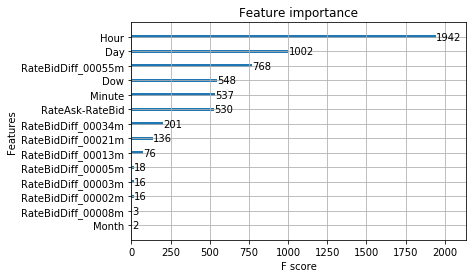

In [15]:
xgb.plot_importance(model);

- Hour(時間)というあんまり関係なさそうなパラメータで判断しまくってる．ココらへんがオーバーフィットの原因？

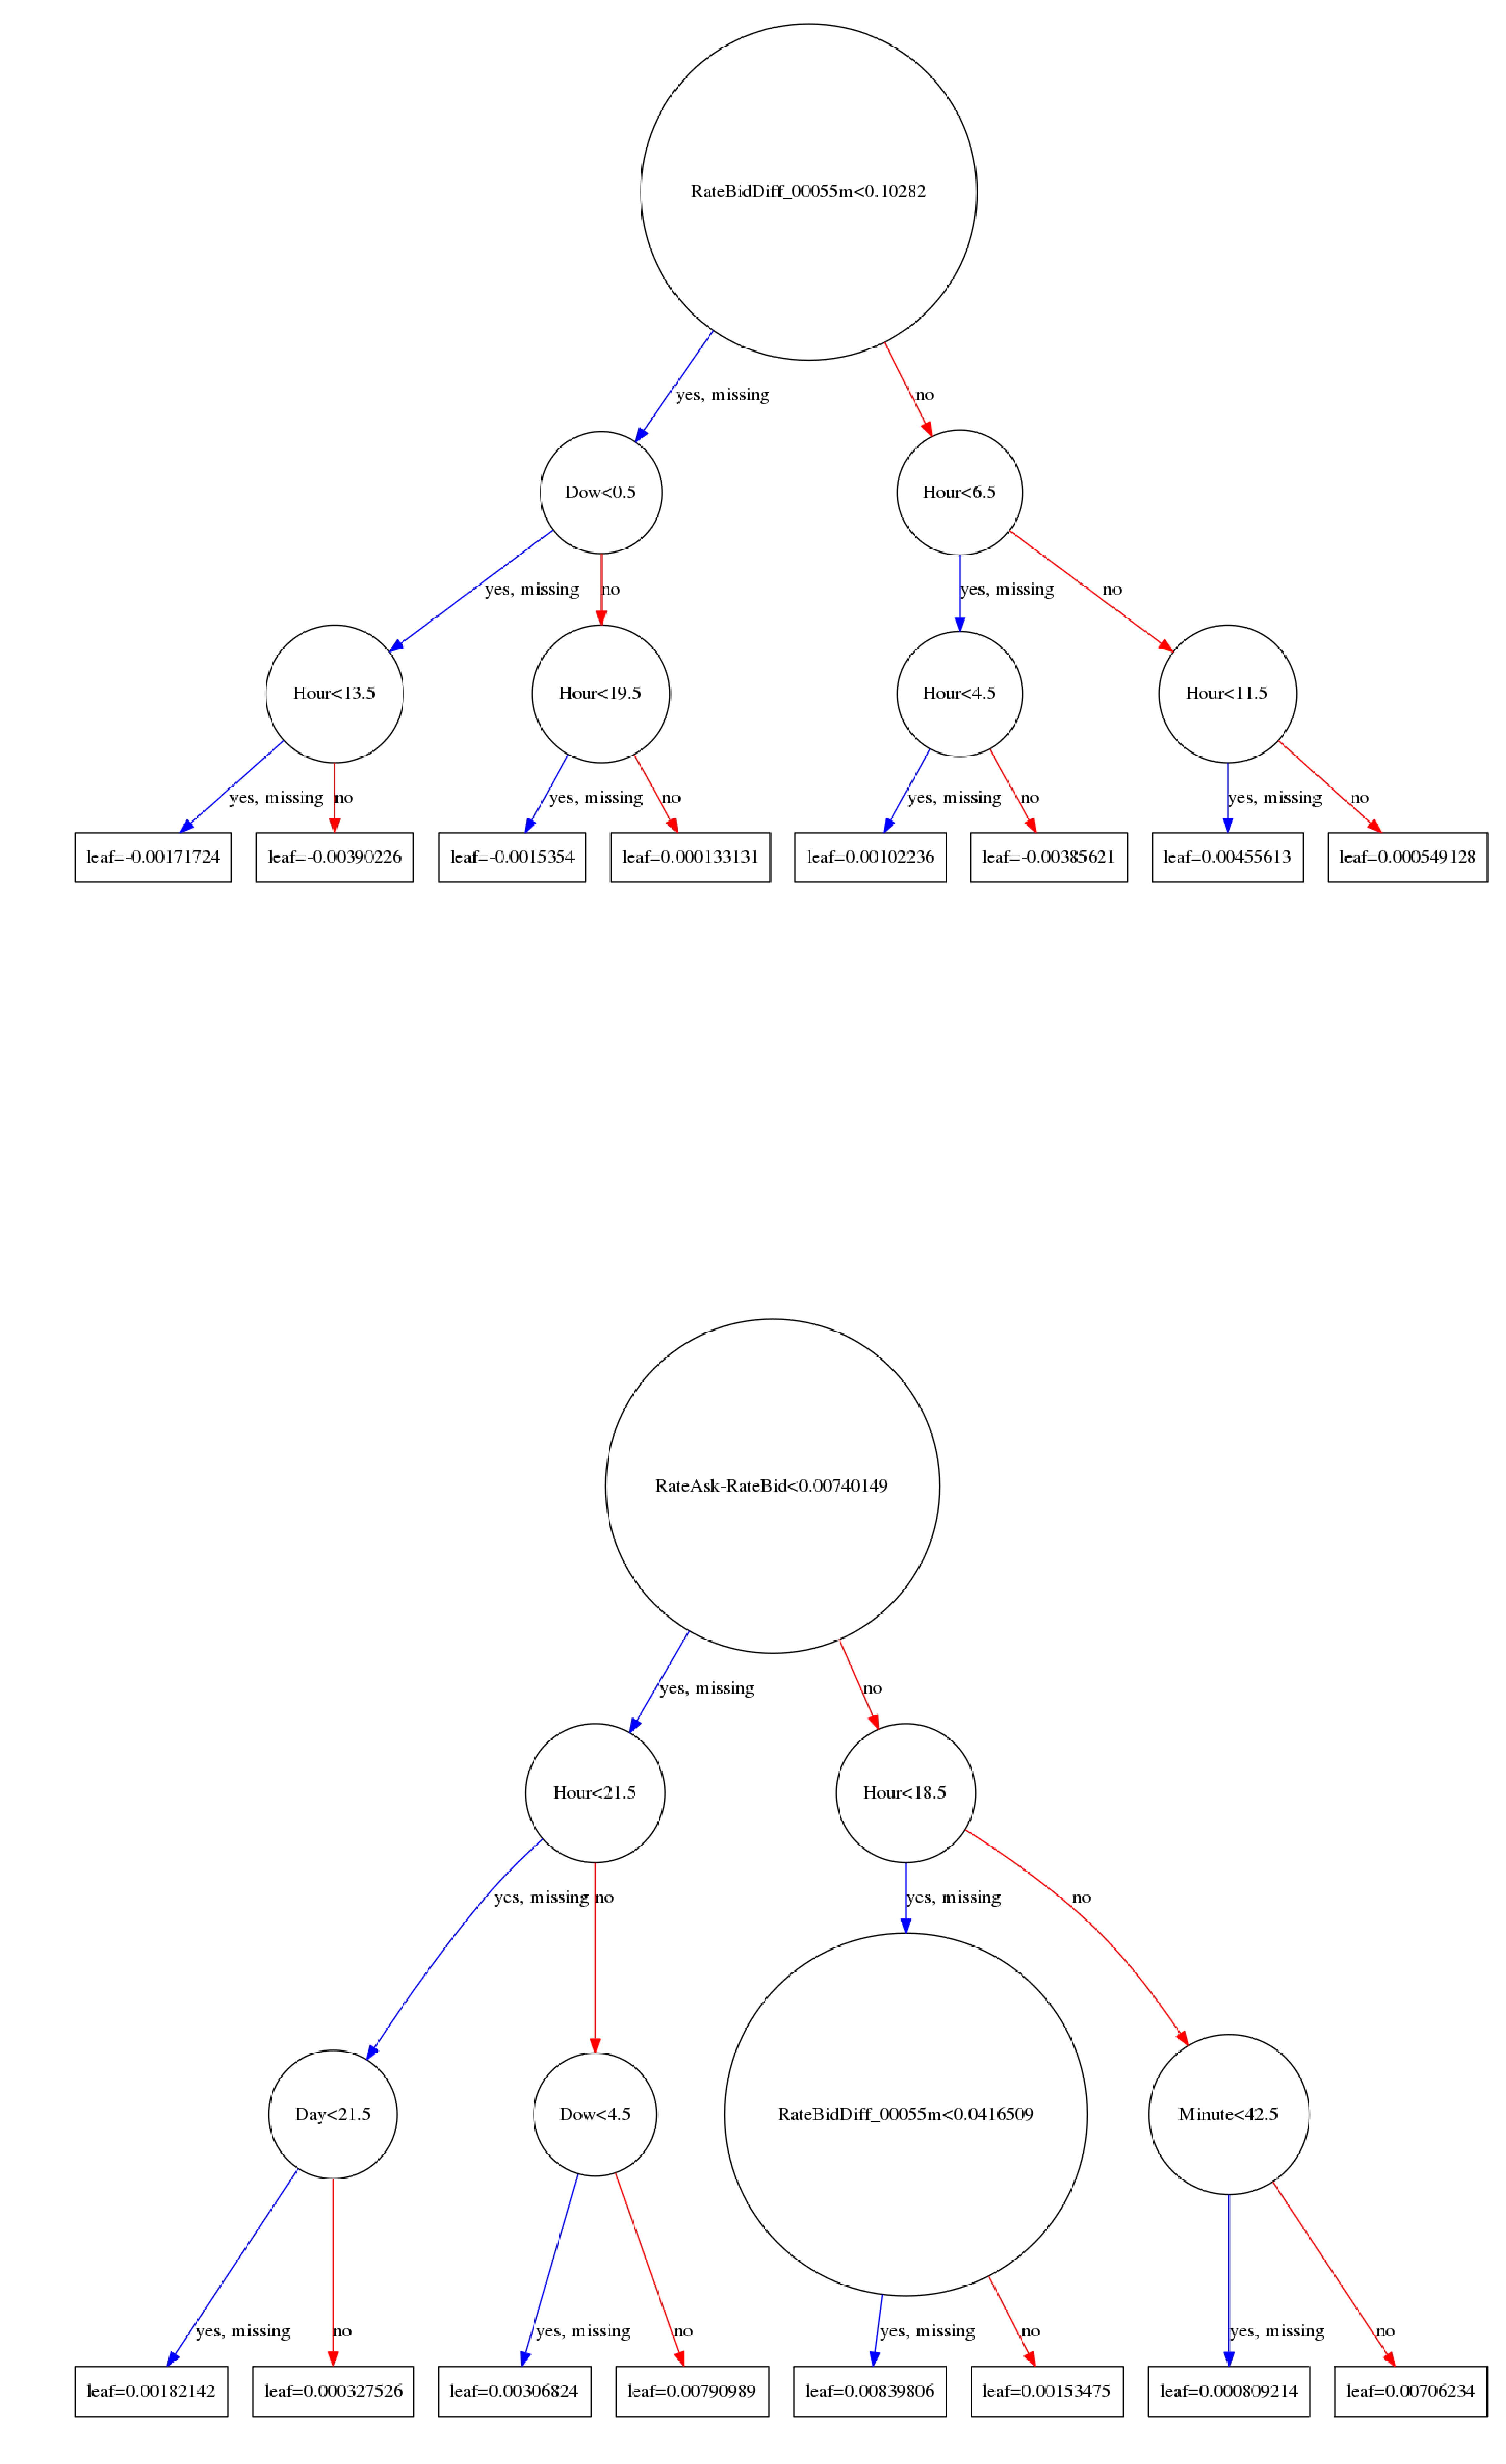

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 24), dpi=400)
xgb.plot_tree(model, num_trees=2, ax=axes[0])
xgb.plot_tree(model, num_trees=3, ax=axes[1])
fig.tight_layout()

### 評価

In [17]:
dtest = xgb.DMatrix(X_test, feature_names=use_columns)
y_preda = model.predict(dtest, ntree_limit=model.best_ntree_limit)
y_pred = np.argmax(y_preda, axis=1)

In [18]:
print "Accuracy: %.4f" % accuracy_score(y_test, y_pred)
print "Recall:       %.4f" % recall_score(y_test, y_pred, average="macro")
print "Precision:  %.4f" % precision_score(y_test, y_pred, average="macro")
print "F1:             %.4f" % f1_score(y_test, y_pred, average="macro")

Accuracy: 0.5792
Recall:       0.3370
Precision:  0.3823
F1:             0.2634


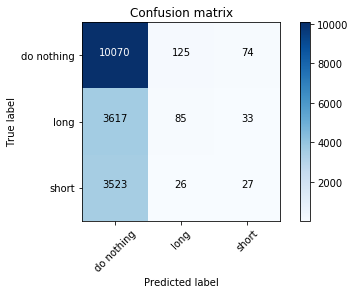

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    cf. http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=ACTION_NAMES, title='Confusion matrix')

- ほとんどの場合は何もしないを最良と判断している．
- 買い(long)の正答率はあまり良くなく，空売り(short)の正答率は良い結果となっている．

## 収益計算

In [20]:
test_df["pred"] = y_pred
test_df["confidence"] = np.max(y_preda, axis=1) # 自信度

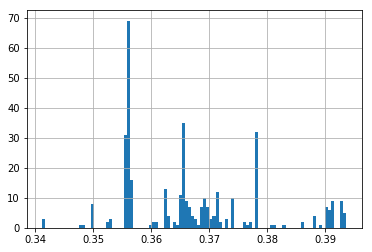

In [21]:
test_df[test_df["pred"] != ACTION_DO_NOTHING]["confidence"].hist(bins=100)

- 3択問題に0.35 〜 0.40付近の自信度しかないということなので，結構当てずっぽうで予測していることがわかる．
- とりあえず，結構自信のありそうな0.4以上なら売買してみることにする．

In [22]:
def adjust_action_type(x, charge=0.003, confidence_lower=0.4):
    """
    手数料や自信度で次の行動を補正する．
    現時点では，予測に自信がある場合のみ買うよう補正しているだけ．
    他にも現在の投資額や予算などから行動を変化させるために使う．
    """
    if (x["pred"] == ACTION_DO_NOTHING) or (x["confidence"] < confidence_lower):
        return ACTION_DO_NOTHING
    if x["pred"] == ACTION_LONG: # 買って売る
        return ACTION_LONG
    if x["pred"] == ACTION_SHORT: # 売って買う
        return ACTION_SHORT

def calc_gain(x, charge=0.003):
    """
    実際に取った行動でのリターン算出
    """
    if x["action_type"] == ACTION_DO_NOTHING:
        return 0
    if x["action_type"] == ACTION_LONG: # 買って売る
        return x["TargetRateBid"] - x["RateAsk"] - 2*charge
    if x["action_type"] == ACTION_SHORT: # 売って買う
        return x["RateBid"] - x["TargetRateAsk"] - 2*charge

test_df["action_type"] = test_df.apply(adjust_action_type, axis=1) # 実際の行動    
test_df["gain"] = test_df.apply(calc_gain, axis=1) # リターン

In [23]:
print "収益の期待値(1ドルあたり): %.4f円" % test_df["gain"].mean()
print "収益の合算値: %.4f円" % test_df["gain"].sum()
print "買った回数: %d" % (test_df["action_type"] == ACTION_LONG).sum()
print "売った回数: %d" % (test_df["action_type"] == ACTION_SHORT).sum()
print "何もしなかった回数: %d" % (test_df["action_type"] == ACTION_DO_NOTHING).sum()

収益の期待値(1ドルあたり): 0.0000円
収益の合算値: 0.0000円
買った回数: 0
売った回数: 0
何もしなかった回数: 17580


## まとめ

- XGBoostで30分後の為替変動を予測してみた．(まだまだロジックの改善が必要)
- 手数料が0.3銭/ドルとしたところ，収益の期待値は，ほぼゼロとなる．(´・ω・｀)
- また，3月末に傾向が変わっており，こういった変化点を検出して対策を取らないと痛い目に合いそう．

## References

> [1]. [Recruit Restaurant Visitor Forecasting](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting), kaggle, 2017.

> [2]. [GAIN Capital](http://ratedata.gaincapital.com/)

> [3]. [Confusion matrix](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html), scikit-learn.